In [1]:
!pip install pmdarima


In [2]:
#importar libresias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
# Configurar visualizaci√≥n
plt.style.use('ggplot')

In [4]:
# Cargar los datos desde el archivo Excel
file_path = "C:/Users/gonza/OneDrive/Desktop/machine learning/Sales_Data.xlsx"
xls = pd.ExcelFile(file_path)

In [5]:
# Leer la primera hoja del archivo Excel
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# Mostrar las primeras filas
df.head()

Order Date      Sales
0 2015-01-01  14205.707
1 2015-02-01   4519.892
2 2015-03-01  55205.797
3 2015-04-01  27906.855
4 2015-05-01  23644.303

In [6]:
#Convertir la columna "Order Date" a formato datetime y establecerla como √≠ndice
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.set_index('Order Date', inplace=True)


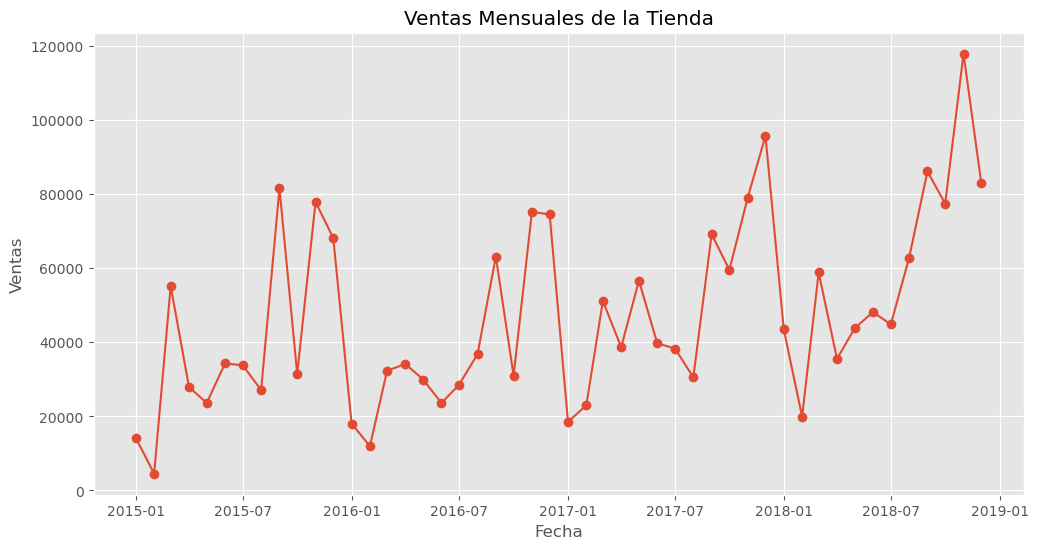

In [7]:
#Visualizar la serie de tiempo
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-')
plt.title('Ventas Mensuales de la Tienda')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()


In [ ]:
#El gr√°fico muestra la evoluci√≥n de las ventas mensuales de la tienda. Se observa una variabilidad significativa y posibles patrones estacionales

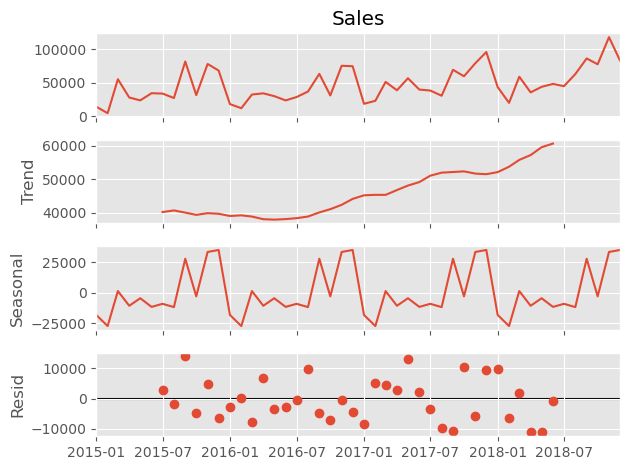

In [8]:
#Realizar la descomposici√≥n de la serie de tiempo:
decomposition = sm.tsa.seasonal_decompose(df['Sales'], model='additive', period=12)
decomposition.plot()
plt.show()


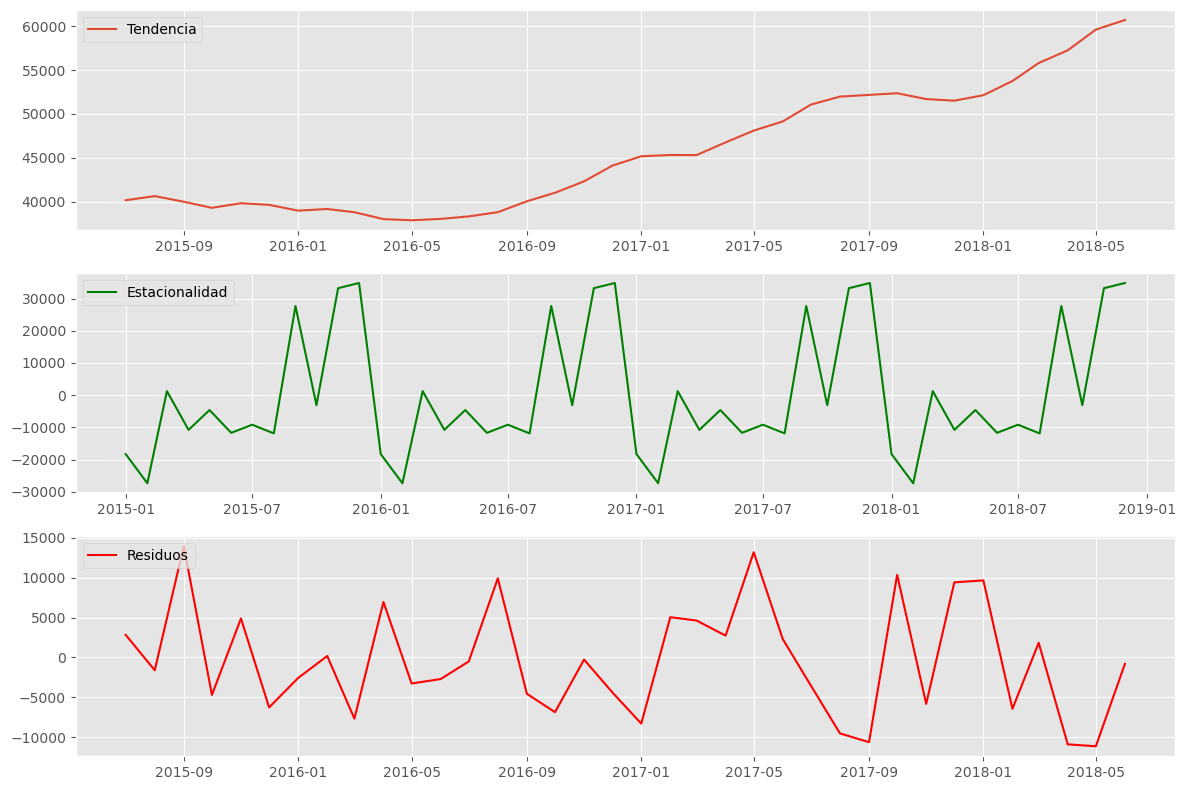

In [82]:
# Descomposici√≥n de la serie de tiempo usando descomposici√≥n estacional
decomposition = sm.tsa.seasonal_decompose(df['Sales'], model='additive', period=12)

# Graficar los componentes descompuestos
plt.figure(figsize=(12, 8))

# Tendencia
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')

# Estacionalidad
plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Estacionalidad', color='green')
plt.legend(loc='upper left')

# Residuos
plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Residuos', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
#La descomposici√≥n de la serie de tiempo muestra:
#Tendencia: Se observa una fluctuaci√≥n en las ventas a lo largo del tiempo, con per√≠odos de crecimiento y ca√≠da.
#Estacionalidad: Existe un patr√≥n estacional claro que se repite cada 12 meses, lo cual indica una periodicidad anual en las ventas.
#Residuos: Los residuos parecen ser relativamente aleatorios, aunque con algunas fluctuaciones.

In [9]:
#Determinar si la serie es estacionaria usando el test de Dickey-Fuller:
adf_test = adfuller(df['Sales'])
print(f"Estad√≠stico ADF: {adf_test[0]}")
print(f"P-valor: {adf_test[1]}")
print(f"Valores cr√≠ticos: {adf_test[4]}")

Estad√≠stico ADF: -4.41613676143077
P-valor: 0.00027791039276670493
Valores cr√≠ticos: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}


In [ ]:
#Dado que el p-valor es menor a 0.05, podemos rechazar la hip√≥tesis nula, lo que significa que la serie ya es estacionaria y no requiere diferenciaci√≥n (ùëë=0).

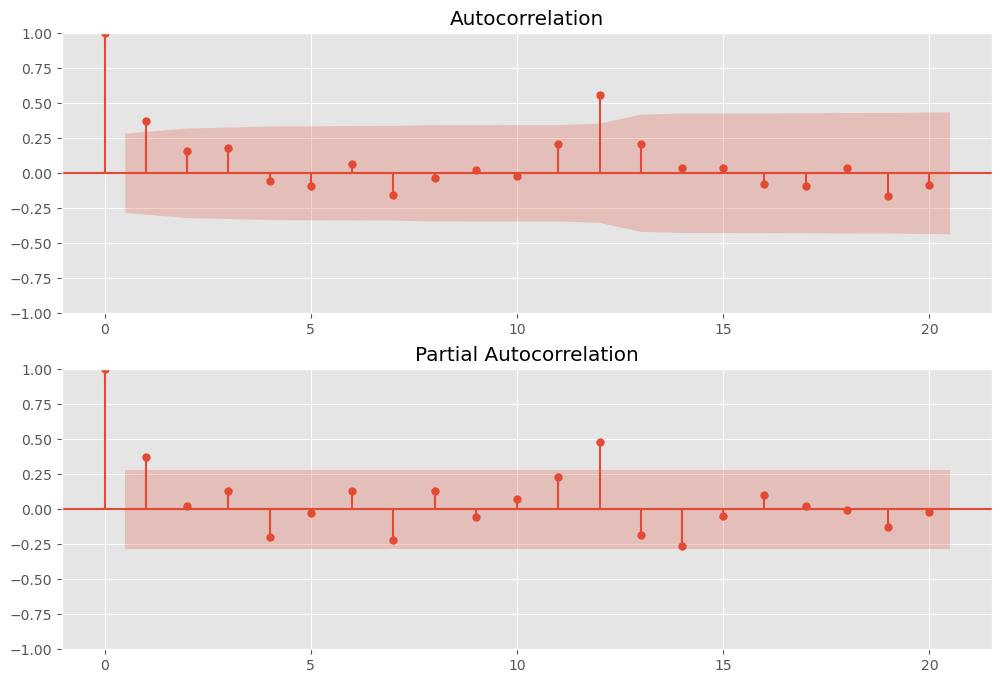

In [10]:
#Determinar los valores de p y ùëû usando ACF y PACF:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Sales'], ax=ax[0], lags=20)  # Funci√≥n de autocorrelaci√≥n
plot_pacf(df['Sales'], ax=ax[1], lags=20) # Funci√≥n de autocorrelaci√≥n parcial
plt.show()

In [12]:
# concluciones de las metricas obtenidas El t√©rmino AR (p=1) es significativo, lo que sugiere que las ventas pasadas afectan las futuras.El t√©rmino MA (q=1) no es significativo, lo que sugiere que el t√©rmino de media m√≥vil podr√≠a eliminarse.

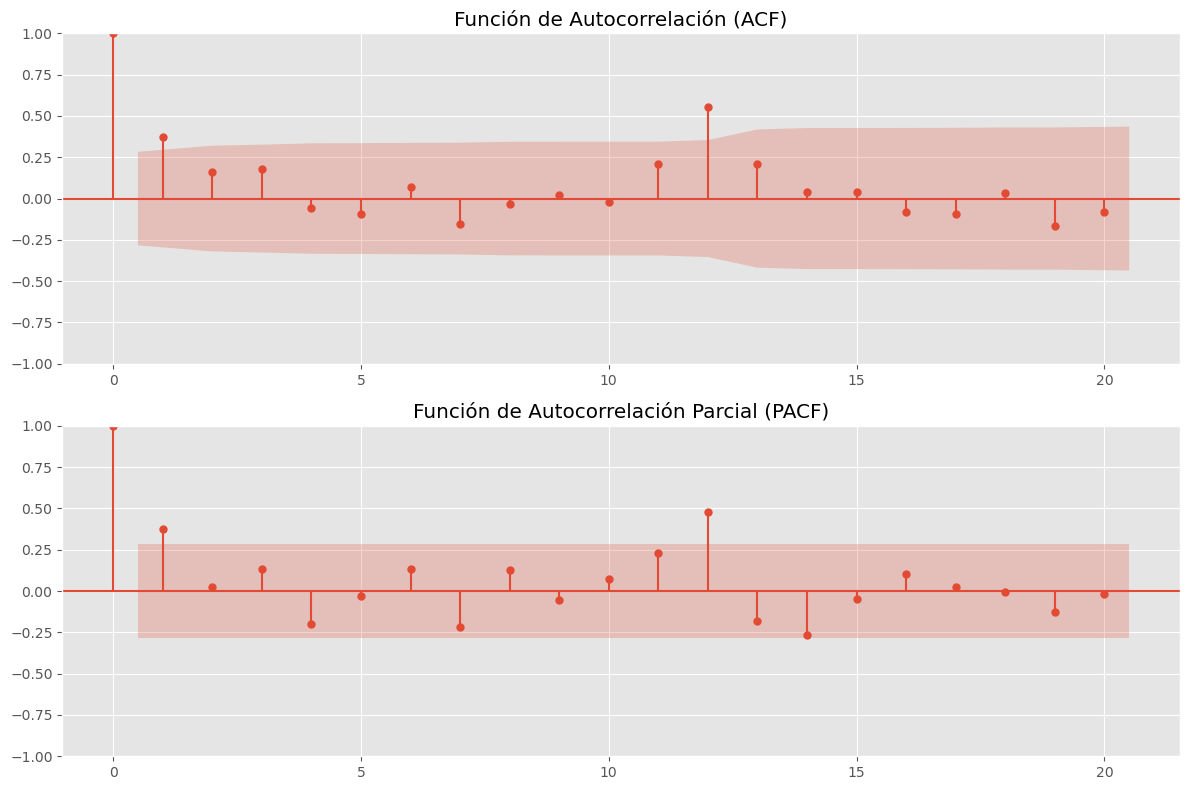

In [13]:
# Graficar ACF y PACF para identificar p y q
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF (Autocorrelaci√≥n)
plot_acf(df['Sales'], ax=ax[0], lags=20)
ax[0].set_title("Funci√≥n de Autocorrelaci√≥n (ACF)")

# PACF (Autocorrelaci√≥n Parcial)
plot_pacf(df['Sales'], ax=ax[1], lags=20)
ax[1].set_title("Funci√≥n de Autocorrelaci√≥n Parcial (PACF)")

plt.tight_layout()
plt.show()


In [14]:
#An√°lisis del ACF (Autocorrelaci√≥n)en la ACF (primer gr√°fico), se observa que el primer rezago es positivo y significativo, y despu√©s los valores caen dentro de la banda sombreada (zona no significativa).Esto indica que hay una posible estructura de media m√≥vil (MA) en la serie, sugiriendo que ùëû=1 o ùëû=2 podr√≠a ser adecuado.

In [15]:
#An√°lisis del PACF (Autocorrelaci√≥n Parcial)En la PACF (segundo gr√°fico), el primer rezago es significativo y el resto cae dentro de la banda sombreada.Esto sugiere que la serie tiene un componente autorregresivo de primer orden.Basado en esto, ùëù=1parece ser una buena elecci√≥n.


In [16]:
#Selecci√≥n de Par√°metros para ARIMA,seg√∫n la interpretaci√≥n de ACF y PACF:ùëù=1(porque la PACF cae despu√©s del primer rezago).d=0 (seg√∫n el test de Dickey-Fuller, la serie ya es estacionaria).q=1 o q=2 (porque la ACF sugiere una estructura de media m√≥vil).Por lo tanto, un modelo ARIMA(1,0,1) o ARIMA(1,0,2) podr√≠a ser adecuado.



In [17]:
# Ajustar modelo  ARIMA(1,0,1)
from statsmodels.tsa.arima.model import ARIMA

modelo_arima_101 = ARIMA(df['Sales'], order=(1, 0, 1))
resultado_arima_101 = modelo_arima_101.fit()

print(resultado_arima_101.summary())


C:\Users\gonza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gonza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gonza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -549.516
Date:                Fri, 14 Feb 2025   AIC                           1107.033
Time:                        23:46:43   BIC                           1114.518
Sample:                    01-01-2015   HQIC                          1109.861
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.712e+04   6372.221      7.394      0.000    3.46e+04    5.96e+04
ar.L1          0.6655      0.280      2.373      0.018       0.116       1.215
ma.L1         -0.3053      0.353     -0.865      0.3

In [18]:
#Modelo ARIMA(1,0,2)
modelo_arima_102 = ARIMA(df['Sales'], order=(1, 0, 2))
resultado_arima_102 = modelo_arima_102.fit()

print(resultado_arima_102.summary())


C:\Users\gonza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gonza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gonza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -549.521
Date:                Fri, 14 Feb 2025   AIC                           1109.042
Time:                        23:46:44   BIC                           1118.398
Sample:                    01-01-2015   HQIC                          1112.578
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.712e+04   7971.235      5.911      0.000    3.15e+04    6.27e+04
ar.L1          0.6714      0.581      1.156      0.248      -0.467       1.810
ma.L1         -0.3088      0.600     -0.515      0.6

In [19]:
#Comparar los Modelos con AIC/BIC
print(f"ARIMA(1,0,1) - AIC: {resultado_arima_101.aic}, BIC: {resultado_arima_101.bic}")
print(f"ARIMA(1,0,2) - AIC: {resultado_arima_102.aic}, BIC: {resultado_arima_102.bic}")


ARIMA(1,0,1) - AIC: 1107.0327691426248, BIC: 1114.5175731862564
ARIMA(1,0,2) - AIC: 1109.0419902374751, BIC: 1118.3979952920147


In [20]:
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])  # Carga la primera hoja
print(df.head())  # Verifica qu√© columnas se est√°n cargando


  Order Date      Sales
0 2015-01-01  14205.707
1 2015-02-01   4519.892
2 2015-03-01  55205.797
3 2015-04-01  27906.855
4 2015-05-01  23644.303


In [21]:
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0], header=None)  # Carga sin asumir encabezados
print(df.head())  # Muestra los primeros datos


                     0          1
0           Order Date      Sales
1  2015-01-01 00:00:00  14205.707
2  2015-02-01 00:00:00   4519.892
3  2015-03-01 00:00:00  55205.797
4  2015-04-01 00:00:00  27906.855


In [22]:
df.columns = df.iloc[0]  # Asigna la primera fila como nombres de columnas
df = df[1:]  # Elimina la primera fila que ahora es redundante
df.columns = df.columns.str.strip()  # Elimina espacios extra en los nombres
print(df.head())  # Verifica la estructura final


0           Order Date      Sales
1  2015-01-01 00:00:00  14205.707
2  2015-02-01 00:00:00   4519.892
3  2015-03-01 00:00:00  55205.797
4  2015-04-01 00:00:00  27906.855
5  2015-05-01 00:00:00  23644.303


In [23]:
df.rename(columns={"Fecha": "Order Date"}, inplace=True)  # Renombra la columna si es necesario
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.set_index('Order Date', inplace=True)
print(df.head())  # Verifica la estructura final


0               Sales
Order Date           
2015-01-01  14205.707
2015-02-01   4519.892
2015-03-01  55205.797
2015-04-01  27906.855
2015-05-01  23644.303


In [52]:
print(df.index)  # Verifica el √≠ndice
print(df.index.freq)  # Verifica si tiene una frecuencia asignada


DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='Order Date', freq=None)
None


In [54]:
df = df.asfreq('MS')  # 'MS' = Month Start (Inicio de mes)
print(df.index.freq)  # Verifica que la frecuencia ahora est√° definida


<MonthBegin>


In [56]:
print(df.isnull().sum())  # Verifica si se generaron valores nulos


0
Sales    0
dtype: int64


In [70]:
df['Sales'] = df['Sales'].fillna(method='ffill')  # Rellenar con el √∫ltimo valor disponible


C:\Users\gonza\AppData\Local\Temp\ipykernel_13748\3296696666.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Sales'] = df['Sales'].fillna(method='ffill')  # Rellenar con el √∫ltimo valor disponible


In [72]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Tama√±o del conjunto de entrenamiento: {len(train)}")
print(f"Tama√±o del conjunto de prueba: {len(test)}")


Tama√±o del conjunto de entrenamiento: 38
Tama√±o del conjunto de prueba: 10


In [74]:
# Asignar frecuencia si es necesario (por si se perdi√≥ en train/test)
train = train.asfreq('MS')
test = test.asfreq('MS')

# Entrenar modelo ARIMA(1,0,1)
modelo_arima_final = ARIMA(train['Sales'], order=(1, 0, 1))
resultado_arima_final = modelo_arima_final.fit()

# Mostrar resumen del modelo
print(resultado_arima_final.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -433.422
Date:                Fri, 14 Feb 2025   AIC                            874.844
Time:                        23:57:55   BIC                            881.395
Sample:                    01-01-2015   HQIC                           877.175
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.218e+04   4314.939      9.776      0.000    3.37e+04    5.06e+04
ar.L1         -0.2080      0.582     -0.357      0.721      -1.348       0.932
ma.L1          0.4566      0.507      0.901      0.3

In [ ]:
# Conclusi√≥n:An√°lisis del Modelo ARIMA(1,0,1)
#El t√©rmino AR (p=1) no es significativo (p-valor=0.721), lo que sugiere que el componente autorregresivo podr√≠a no ser necesario.
#El t√©rmino MA (q=1) tampoco es significativo (p-valor=0.901), lo que sugiere que la estructura de media m√≥vil no est√° contribuyendo mucho al modelo.
#La constante del modelo es altamente significativa (p=0.000), lo que sugiere que el modelo predice una media constante en las ventas.


In [76]:
# Generar predicciones en el conjunto de prueba,evaluamos el modelo en el conjunto de prueba para ver qu√© tan bien predice:
predicciones = resultado_arima_final.forecast(steps=len(test))


In [78]:
# Calcular m√©tricas de error
mae = mean_absolute_error(test['Sales'], predicciones)
mse = mean_squared_error(test['Sales'], predicciones)

print(f"MAE (Error Absoluto Medio): {mae}")
print(f"MSE (Error Cuadr√°tico Medio): {mse}")


MAE (Error Absoluto Medio): 25478.756167456133
MSE (Error Cuadr√°tico Medio): 1153031860.2040734


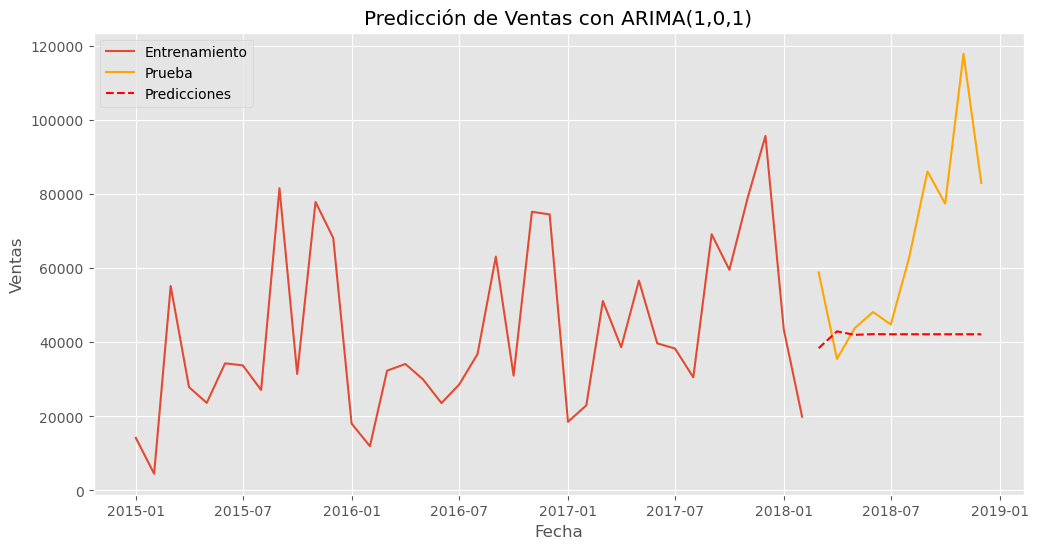

In [80]:
# Graficar las predicciones vs datos reales
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Sales'], label="Entrenamiento")
plt.plot(test.index, test['Sales'], label="Prueba", color='orange')
plt.plot(test.index, predicciones, label="Predicciones", linestyle='dashed', color='red')
plt.legend()
plt.title("Predicci√≥n de Ventas con ARIMA(1,0,1)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid(True)
plt.show()

In [ ]:
#concluciones:
#El modelo no captura la tendencia de crecimiento en los datos de prueba.
#El modelo ARIMA(1,0,1) predice valores constantes en la l√≠nea de predicci√≥n (rojo discontinua).
#Mientras que los valores reales de prueba (naranja) muestran un aumento significativo en ventas.
#Conclusi√≥n: El modelo no captura la tendencia creciente, modelo predice un valor medio constante
#ARIMA(1,0,1) no est√° ajustando la variabilidad observada en los datos.
#Esto sugiere que los t√©rminos AR y MA no son adecuados para capturar los cambios en la serie.
Ô∏è#Fuerte diferencia entre valores reales y predicciones.
#Las ventas reales (l√≠nea naranja) fluct√∫an mucho, mientras que el modelo predice un valor plano.
#Esto indica que el modelo no es adecuado para capturar la estacionalidad y la tendencia de los datos.